# Image Captioning: hybrid ViT-LSTM model


This notebook use a ViT-LSTM model for image captioning


**References**
 
1. Udacity's Computer Vision Nanodegree
2. COCO API: https://github.com/cocodataset/cocoapi
3. This notebook tells how to download the COCO Dataset https://colab.research.google.com/github/rammyram/image_captioning/blob/master/Image_Captioning.ipynb
4. Google's paper using LSTM for image captioning https://arxiv.org/pdf/1411.4555.pdf
5. HuggingFace's ViT implementation: https://huggingface.co/docs/transformers/model_doc/vit

**Notes**

This notebook was run on my local machine (Windows, GTX 1050Ti)

## Import Libraries

In [1]:
!pip install transformers

In [2]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, BatchSampler
from torchtext.data.metrics import bleu_score

from PIL import Image
import nltk
nltk.download('punkt')

import sys
sys.path.append("/opt/cocoapi/PythonAPI")

import math
import time
import pickle
import json
import os
import urllib
import zipfile
import random
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

from pycocotools.coco import COCO

# vision transformer
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor, ViTForImageClassification

# check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

C:\ProgramData\Anaconda3\envs\pytorch-gpu\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\envs\pytorch-gpu\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PandaEgg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


cuda


## Build Vocabulary File

We built the vocabulary from the training data set (`captions_train2014.json`).

Implementation of the vocabulary object is adapted from *Udacity Computer Vision Nanodegree*, which is written in the file `cococap_vocabulary_obj.py`

In [3]:
from cococap_vocabulary_obj import Vocabulary

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PandaEgg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# minimum count required to add to the vocabulary list
VOCAB_THRESHOLD = 5

# build vocab file from training data
train_vocab = Vocabulary(vocab_threshold=VOCAB_THRESHOLD,
                         vocab_file="./vocab.pkl",
                         start_word="<start>",
                         end_word="<end>",
                         unk_word="<unk>",
                         annotations_file="./opt/cocoapi/annotations/captions_train2014.json",
                         vocab_from_file=True)

# size of vocab
VOCAB_SIZE = len(train_vocab)
print("VOCAB_SIZE: {}".format(VOCAB_SIZE))

Vocabulary successfully loaded from vocab.pkl file!
VOCAB_SIZE: 8852


## Data Transforms

We create two kinds of datatransforms.
- `transform_train` has data augmentation (random crop and random horizontal flip)
- `transform_eval` does not have data augmentation at all

In [5]:
# training data transform
transform_train = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# validation/test data transform
transform_eval = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## Custom COCO Datasets

There are 3 types of cumstom COCO datasets we will use. Codes can be found in `cococap_datasets.py`

**CoCoDataset_DevMode**
- For training and evaluation (loss) in batches. Batch_size >= 1
- Yields **processed image tensor** and **tokenized captions**
- Has method `get_data_indices`, which random samples a batch of captions with the same length

**CoCoDataset_BLEUMode**
- For calculating BLEU scores. **Batch_size must be 1**
- Yields **processed image tensor**, **tokenized captions**, and **Image ID**
- Has method `get_data_indices`, which random samples a single data

**CoCoDataset_CaptionMode**
- For predicting captions for the train/val/test dataset. **Batch_size must be 1**
- Yields **original image matrix** and **processed image tensor**

In [6]:
from cococap_datasets import CoCoDataset_DevMode, CoCoDataset_BLEUMode, CoCoDataset_CaptionMode

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PandaEgg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Create training and validation dataset / dataloader

In [7]:
# batch size
BATCH_SIZE = 32

# training dataset for training purposes
dataset_train = CoCoDataset_DevMode(transform=transform_train,  # with augmentation
                                    batch_size=BATCH_SIZE,
                                    vocab_file=train_vocab,
                                    annotations_file="./opt/cocoapi/annotations/captions_train2014.json",
                                    img_folder="./images/train2014/")

training_batch_sampler = BatchSampler(sampler=SubsetRandomSampler(indices=dataset_train.get_data_indices()),
                                      batch_size=dataset_train.batch_size,
                                      drop_last=False)

dataloader_train = DataLoader(dataset=dataset_train, batch_sampler=training_batch_sampler)


# validation dataset for training purposes
dataset_val = CoCoDataset_DevMode(transform=transform_eval,  # no augmentation
                                  batch_size=BATCH_SIZE,
                                  vocab_file=train_vocab,
                                  annotations_file="./opt/cocoapi/annotations/captions_val2014.json",
                                  img_folder="./images/val2014/")

val_batch_sampler = BatchSampler(sampler=SubsetRandomSampler(indices=dataset_val.get_data_indices()),
                                 batch_size=dataset_val.batch_size,
                                 drop_last=False)

dataloader_val = DataLoader(dataset=dataset_val, batch_sampler=val_batch_sampler)

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████████████████████████████████████████████| 414113/414113 [00:49<00:00, 8300.16it/s]


loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████████████████████████████████████████████| 202654/202654 [00:24<00:00, 8321.56it/s]


## Model (Encoder and Decoder)

In [102]:
%load_ext autoreload
%autoreload 2
from cococap_model import EncoderViT, DecoderRNN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
## Create encoder
EMBED_SIZE = 512

encoder = EncoderViT(embed_size=EMBED_SIZE)

print(encoder)

EncoderViT(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): PatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0): ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermediate): Vi

In [104]:
## Create decoder
HIDDEN_SIZE = 512

decoder = DecoderRNN(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE)

print(decoder)

DecoderRNN(
  (embedding): Embedding(8852, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=8852, bias=True)
)


In [105]:
print("[Encoder] Number of trainable parameters: {}".format(sum(param.numel() for param in encoder.parameters() if param.requires_grad)))
print("[Decoder] Number of trainable parameters: {}".format(sum(param.numel() for param in decoder.parameters() if param.requires_grad)))

[Encoder] Number of trainable parameters: 393728
[Decoder] Number of trainable parameters: 11174548


## Training

In [106]:
def train_model(model_name, enc, dec, num_epochs, criterion, optimizer, device):
    """
    Train the model
    Args
        model_name: (str) unique name of the model to save
        enc: Pytorch DL model for encoder
        dec: Pytorch DL model for decoder
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
    """
    # number of steps per epoch
    train_steps_per_epoch = math.ceil(len(dataloader_train.dataset.caption_lengths)/dataloader_train.batch_sampler.batch_size)
    val_steps_per_epoch = math.ceil(len(dataloader_val.dataset.caption_lengths)/dataloader_val.batch_sampler.batch_size)
    
    
    # iterate epoch
    for epoch in range(1, num_epochs+1):

        """
        Training
        """
        print("=== Training ===")

        enc.train()
        dec.train()
        
        train_total_loss = 0.0
        train_n = 0

        for step_i in range(1, train_steps_per_epoch+1):
            # sample training indices from dataloader_train
            training_indices = dataloader_train.dataset.get_data_indices()
            # batch sampler
            new_sampler = SubsetRandomSampler(indices=training_indices)
            # load
            dataloader_train.batch_sampler.sampler = new_sampler

            # load inputs
            images_t, captions_t = next(iter(dataloader_train))

            images_t = images_t.to(device)
            captions_t = captions_t.to(device)

            # zero grad
            optimizer.zero_grad()

            # encode
            features_t = enc(images_t)

            # decode
            outputs_t = dec(features_t, captions_t)

            # loss
            loss = criterion(outputs_t.view(-1, VOCAB_SIZE), captions_t.view(-1))

            loss.backward()
            optimizer.step()
            
            train_total_loss += loss.item() * features_t.size(0)
            # number of data seen
            train_n += features_t.size(0)
            # mean loss
            train_mean_loss = train_total_loss / train_n

            # training stats
            stats = "Epoch {}/{}  Step {}/{}\tLoss: {:.4f}  Perplexity: {:.4f}\t[Overall] Loss: {:.4f}\tPerplexity: {:.4f}".format(
                epoch, num_epochs, step_i, train_steps_per_epoch, loss.item(), np.exp(loss.item()), train_mean_loss, np.exp(train_mean_loss))

            # same line print out
            print('\r' + stats, end="")
            sys.stdout.flush()
            
            if step_i == train_steps_per_epoch:
                print('\r' + stats)
            
        """
        Evaluation
        """
        print("=== Evaluation ===")

        enc.eval()
        dec.eval()

        eval_total_loss = 0.0
        eval_n = 0

        for step_i in range(1, val_steps_per_epoch+1):
            # sample indices
            val_indices = dataloader_val.dataset.get_data_indices()
            # subset sampler
            dataloader_val.batch_sampler.sampler = SubsetRandomSampler(indices=val_indices)
            # load inputs
            images_t, captions_t = next(iter(dataloader_val))
            images_t = images_t.to(device)
            captions_t = captions_t.to(device)

            with torch.no_grad():
                # encode
                features_t = enc(images_t)
                # decode
                outputs_t = dec(features_t, captions_t)
                # loss
                loss = criterion(outputs_t.view(-1, VOCAB_SIZE), captions_t.view(-1))
                eval_total_loss += loss.item() * features_t.size(0)
                # number of data seen
                eval_n += features_t.size(0)
                # mean loss
                eval_mean_loss = eval_total_loss / eval_n

            # evaluation stats
            stats = "Epoch {}/{}  Step {}/{}\tLoss: {:.4f}  Perplexity: {:.4f}\t[Overall] Loss: {:.4f}\tPerplexity: {:.4f}".format(
                epoch, num_epochs, step_i, val_steps_per_epoch, loss.item(), np.exp(loss.item()), eval_mean_loss, np.exp(eval_mean_loss))

            # same line print out
            print('\r' + stats, end="")
            sys.stdout.flush()
            
            if step_i == val_steps_per_epoch:
                print('\r' + stats)
            
        # save encoder
        torch.save(enc.state_dict(), os.path.join("./saved_models", "encoder_" + model_name + "_ep" + str(epoch) + ".pth"))
        torch.save(dec.state_dict(), os.path.join("./saved_models", "decoder_" + model_name + "_ep" + str(epoch) + ".pth"))

    return enc, dec

## Train the Model

In [107]:
# move to gpu
encoder = encoder.to(device)
decoder = decoder.to(device)

# unique model name for saving the weights
model_name = "020722"

# loss function
criterion = nn.CrossEntropyLoss()

# trainable parameters
params = list(decoder.parameters()) + list(encoder.parameters())

# optimizer
optimizer = torch.optim.Adam(params, lr=0.001)

# train
encoder, decoder = train_model(model_name, encoder, decoder, num_epochs=5, criterion=criterion, optimizer=optimizer, device=device)

=== Training ===
Epoch 1/5  Step 12942/12942	Loss: 1.9621  Perplexity: 7.1143	[Overall] Loss: 2.3286	Perplexity: 10.26381
=== Evaluation ===
Epoch 1/5  Step 6333/6333	Loss: 2.0675  Perplexity: 7.9047	[Overall] Loss: 2.2250	Perplexity: 9.253404
=== Training ===
Epoch 2/5  Step 12942/12942	Loss: 1.8700  Perplexity: 6.4883	[Overall] Loss: 2.0255	Perplexity: 7.58022
=== Evaluation ===
Epoch 2/5  Step 6333/6333	Loss: 2.1816  Perplexity: 8.8609	[Overall] Loss: 2.2015	Perplexity: 9.038391
=== Training ===
Epoch 3/5  Step 12942/12942	Loss: 1.6965  Perplexity: 5.4547	[Overall] Loss: 1.9477	Perplexity: 7.01233
=== Evaluation ===
Epoch 3/5  Step 6333/6333	Loss: 2.3494  Perplexity: 10.4796	[Overall] Loss: 2.2112	Perplexity: 9.1265
=== Training ===
Epoch 4/5  Step 12942/12942	Loss: 2.0559  Perplexity: 7.8141	[Overall] Loss: 1.9055	Perplexity: 6.722963
=== Evaluation ===
Epoch 4/5  Step 6333/6333	Loss: 2.1347  Perplexity: 8.4547	[Overall] Loss: 2.2129	Perplexity: 9.141895
=== Training ===
Epoch 5/5 

## Evaluation - BLEU Score

### Create datasets for BLEU score calculation

In [108]:
# training dataset for BLEU calculation
single_dataset_train = CoCoDataset_BLEUMode(transform=transform_eval,  # no augmentation
                                            batch_size=1,
                                            vocab_file=train_vocab,
                                            annotations_file="./opt/cocoapi/annotations/captions_train2014.json",
                                            img_folder="./images/train2014/")

single_dataloader_train = DataLoader(dataset=single_dataset_train, batch_size=1, shuffle=False)


# for BLEU calculation
single_dataset_val = CoCoDataset_BLEUMode(transform=transform_eval,  # no augmentation
                                          batch_size=1,
                                          vocab_file=train_vocab,
                                          annotations_file="./opt/cocoapi/annotations/captions_val2014.json",
                                          img_folder="./images/val2014/")

single_dataloader_val = DataLoader(dataset=single_dataset_val, batch_size=1, shuffle=False)

loading annotations into memory...
Done (t=2.47s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████████████████████████████████████████████| 414113/414113 [00:46<00:00, 8888.50it/s]


loading annotations into memory...
Done (t=2.05s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████████████████████████████████████████████| 202654/202654 [00:22<00:00, 9074.29it/s]


In [109]:
%load_ext autoreload
%autoreload 2
from cococap_eval_funcs import eval_BLEU

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# training dataset
bleu, _, _ = eval_BLEU(encoder, decoder, single_dataloader_train, train_vocab, device)
print("\n")
print("BLEU Scores: {}".format(bleu))

In [110]:
# validation dataset
bleu, _, _ = eval_BLEU(encoder, decoder, single_dataloader_val, train_vocab, device)
print("\n")
print("BLEU Scores: {}".format(bleu))

[202654/202654] Calculating BLEU scores...


BLEU Scores: [0.6917943413316052, 0.48706869573715855, 0.341822713550284, 0.2366931041004892]


# Inference: Generate Captions for Test Dataset

We use the model to predict the captions for the images in the COCO test dataset.

In [122]:
%load_ext autoreload
%autoreload 2
from cococap_auxfuncs import random_sample_testdata

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
# for captioning demo
single_dataset_test = CoCoDataset_CaptionMode(transform=transform_eval,
                                              batch_size=1,
                                              vocab_file=train_vocab,
                                              annotations_file="./opt/cocoapi/annotations/image_info_test2014.json",
                                              img_folder="./images/test2014/")

dataloader_test = DataLoader(dataset=single_dataset_test, batch_size=1, shuffle=True)

a large red fire truck parked in a parking lot .


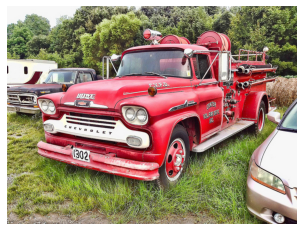

In [124]:
# sample an image
random_sample_testdata(dataloader_test, encoder, decoder, train_vocab, device)

a horse pulling a wagon with a man in the back


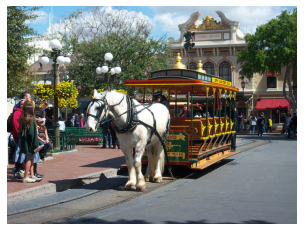

In [125]:
# sample an image
random_sample_testdata(dataloader_test, encoder, decoder, train_vocab, device)

a person riding a surf board on a wave


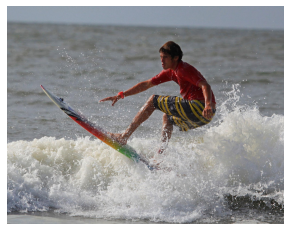

In [128]:
# sample an image
random_sample_testdata(dataloader_test, encoder, decoder, train_vocab, device)

# Inference: Generate Captions for Custom Images

We use the model to predict the captions for the custom images. Custom images were first uploaded to the `custom_test_images` folder.

In [134]:
%load_ext autoreload
%autoreload 2
from cococap_auxfuncs import image_captioning_custom_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


a table topped with a plate of fruit and a cup of coffee .


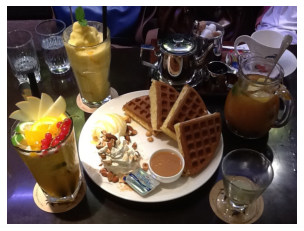

In [149]:
# example custom image
image_captioning_custom_image("./custom_test_images/IMG_0630.jpg", encoder, decoder, transform_eval, train_vocab, device)

a stuffed bear that is sitting on a table .


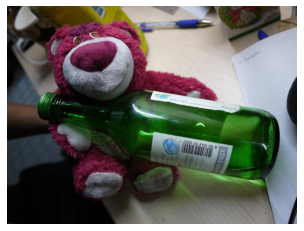

In [150]:
# example custom image
image_captioning_custom_image("./custom_test_images/IMG_0616.jpg", encoder, decoder, transform_eval, train_vocab, device)

a cat is sitting on a chair with a remote control on it .


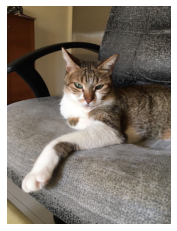

In [151]:
# example custom image
image_captioning_custom_image("./custom_test_images/IMG_1357.jpg", encoder, decoder, transform_eval, train_vocab, device)

a stuffed animal sits on a bed with a stuffed animal .


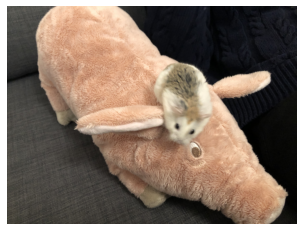

In [139]:
# example custom image
image_captioning_custom_image("./custom_test_images/IMG_4446.jpg", encoder, decoder, transform_eval, train_vocab, device)